In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Import data

In [2]:
train_df = pd.read_csv('raw_data/train.csv')
test_df = pd.read_csv('raw_data/test.csv')
submission_df = pd.read_csv('raw_data/sample_submission.csv')

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Data exploration

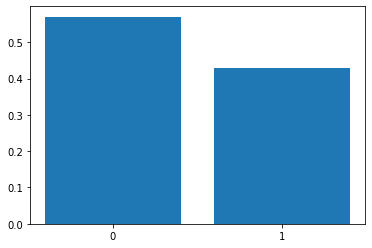

In [4]:
plt.bar((train_df['target'].value_counts()/len(train_df)).index,train_df['target'].value_counts()/len(train_df))
plt.xticks(ticks=train_df['target'].unique())
plt.show()

Target classes are slightly imbalanced, but shouldn't be a problem (bigger class <70%).

### Preprocessing

#### Basic for all types of data

In [5]:
train_df.isnull().sum()/len(train_df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

First model won't use location. Given that there are less than 1% of tweets missing keyword, I'll drop the rows with NaNs in that column

In [6]:
train_df = train_df[train_df['keyword'].notna()]

In [7]:
len(train_df.drop_duplicates()) == len(train_df)

True

No duplicates found

In [8]:
X_train = train_df['text']
y_train = train_df['target']

#### Basic for text

Create custom transformer for basic text preprocessing. Easier to play around later on.

In [9]:
def remove_digits(string):
    """Remove digits from the given string"""
    return ''.join(letter for letter in string if not letter.isdigit())

In [10]:
from nltk.tokenize import word_tokenize

def tokenize(string):
    """Returns list of words componing the string"""
    return word_tokenize(string)

def detokenize(tokenized_string):
    return ' '.join(tokenized_string)

In [11]:
def remove_stopwords(tokenized_string, stopwords):
    """Given a list of words, removes all words that are in stopwords"""
    return [word for word in tokenized_string if word not in stopwords]

In [12]:
from nltk.stem import WordNetLemmatizer

def lemmatize(tokenized_string):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokenized_string]

In [13]:
from sklearn.base import TransformerMixin, BaseEstimator
import string
from nltk.corpus import stopwords

class BasicTextProcessor(TransformerMixin, BaseEstimator):
    """
    Transformer that gets fed pd.Series containing text. Can be defined which actions should be executed:
    - lower
    - remove user tags
    - remove special programming characters
    - remove links
    - remove digits
    - exclude certain types of punctuation (everything else will be removed)
    - exclude certain stopwords (everything else will be removed)
    - lemmatize
    """
    def __init__(self, lower=True, remove_tags=True, remove_specials=[r'&amp;', r'\\n'], remove_links=True, remove_num=True, excl_punct=None, excl_stopwords=None, lemmatize=True):
        self.lower = lower
        self.remove_tags = remove_tags
        self.remove_specials = remove_specials
        self.remove_links = remove_links
        self.remove_num = remove_num
        self.excl_punct = excl_punct
        self.excl_stopwords = excl_stopwords
        self.lemmatize = lemmatize
    
    def fit(self, X, y=None):
        if self.excl_punct:
            self.punctuation = ''.join(i for i in string.punctuation if i not in self.excl_punct)
        else:
            self.punctuation = string.punctuation
        if self.excl_stopwords:
            self.stopwords = [i for i in stopwords.words("english") if i not in self.excl_stopwords]
        else:
            self.stopwords = stopwords.words("english")
        
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        
        if self.remove_specials:
            for special in self.remove_specials:
                X_transformed = X_transformed.str.replace(special,' ',regex=True)
        if self.lower:
            X_transformed = X_transformed.str.lower()
        if self.remove_tags:
            X_transformed = X_transformed.str.replace(r'@(\w+)','USER',regex=True)
        if self.remove_links:
            X_transformed = X_transformed.str.replace(r'http(\S+)','LINK',regex=True)
        if self.remove_num:
            X_transformed = X_transformed.apply(remove_digits)
        
        # substitute ' with space for better removal of stopwords
        if "'" in self.punctuation:
            X_transformed = X_transformed.str.replace("'",' ',regex=False)
        for punct in self.punctuation:
            X_transformed = X_transformed.str.replace(punct,'',regex=False)
        
        # actions on tokenized string
        X_transformed_tokenized = X_transformed.apply(tokenize)
        X_transformed_tokenized = X_transformed_tokenized.apply(remove_stopwords,stopwords=self.stopwords)
        X_transformed_tokenized = X_transformed_tokenized.apply(lemmatize)
        
        return X_transformed_tokenized.apply(detokenize)

#### Build basic pipeline for tweets

In [14]:
from sklearn import set_config
set_config(display="diagram")

In [15]:
from sklearn.pipeline import Pipeline

basic_pipe = Pipeline([
    ('basic', BasicTextProcessor())
])

basic_pipe

Pipeline(steps=[('basic', BasicTextProcessor())])

#### Vectorize

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

#### Build preprocessing pipeline

In [17]:
preproc_pipe = Pipeline([
    ('basic', basic_pipe),
    ('tfidf', tfidf)
])

preproc_pipe

Pipeline(steps=[('basic', Pipeline(steps=[('basic', BasicTextProcessor())])),
                ('tfidf', TfidfVectorizer())])

### Dimensionality Reduction

We are overfitting. Let's try reducing dimensionality with SVD (i.e. PCA for sparse matrices, such as vectorized natural language)

In [18]:
from sklearn.decomposition import TruncatedSVD

X_train_preproc = preproc_pipe.fit_transform(X_train)
model_reduce = TruncatedSVD(n_components=200, n_iter=10).fit(X_train_preproc)

model_reduce.explained_variance_ratio_.sum()

0.27484895209671384

In [19]:
X_train_reduced = model_reduce.transform(X_train_preproc)

### Modelling

#### Baseline score

In [20]:
baseline = (train_df['target'].value_counts()/len(train_df))[1]
baseline

0.4275688559322034

In [21]:
from sklearn.model_selection import cross_validate, learning_curve
from sklearn.decomposition import TruncatedSVD

def get_model_and_curves(X, y, model):

    results = cross_validate(model, X, y, cv=5, scoring='f1')
    print("F1 score:", results['test_score'].mean())
    
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X,
                                                        y,
                                                        cv=5,
                                                        scoring='f1')
    plt.plot(train_sizes,np.mean(train_scores,axis=1), label='train_scores')
    plt.plot(train_sizes,np.mean(test_scores,axis=1), label='test_scores')
    plt.xlabel('train_sizes')
    plt.ylabel('F1 scores')
    plt.ylim(0.3,0.9)
    plt.legend()
    plt.plot()

#### Logistic Regression

F1 score: 0.5867371184230765


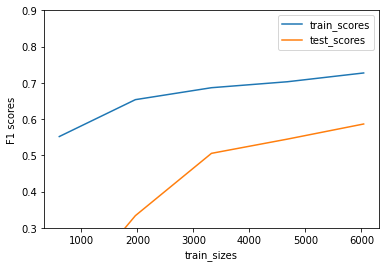

In [22]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=10000)
get_model_and_curves(X_train_reduced,y_train,logreg_model)

#### KNN

F1 score: 0.4975643029019232


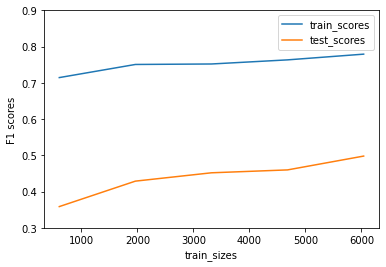

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
get_model_and_curves(X_train_reduced,y_train,knn_model)

#### Naive Bayes Algorithm

F1 score: 0.5878453726825729


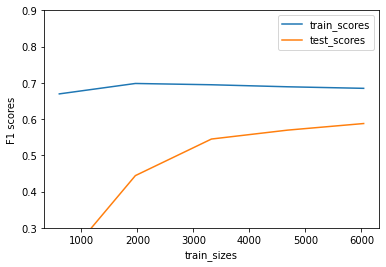

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

X_train_reduced_nb = MinMaxScaler(feature_range=(10, 10000)).fit_transform(X_train_reduced)
nb_model = MultinomialNB()
get_model_and_curves(X_train_reduced_nb,y_train,nb_model)

### Submission

#### Create final pipe

In [25]:
final_pipe = Pipeline([
    ('preproc', preproc_pipe),
    ('dim_reduce', TruncatedSVD(n_components=200, n_iter=10)),
    ('model', LogisticRegression(max_iter=10000))
])

final_pipe

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('basic',
                                  Pipeline(steps=[('basic',
                                                   BasicTextProcessor())])),
                                 ('tfidf', TfidfVectorizer())])),
                ('dim_reduce', TruncatedSVD(n_components=200, n_iter=10)),
                ('model', LogisticRegression(max_iter=10000))])

In [26]:
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('basic',
                                  Pipeline(steps=[('basic',
                                                   BasicTextProcessor())])),
                                 ('tfidf', TfidfVectorizer())])),
                ('dim_reduce', TruncatedSVD(n_components=200, n_iter=10)),
                ('model', LogisticRegression(max_iter=10000))])

#### Create submission file

In [27]:
y_pred = final_pipe.predict(test_df['text'])

In [28]:
submission_pred = pd.DataFrame({
    'id': test_df['id'],
    'target': y_pred
})

In [29]:
submission_pred.to_csv('submission.csv',index=False)